#Model testing

In [ ]:
import os
import librosa
import joblib
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio, display
import IPython.display as ipd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The strategy used below is averaging. The individual predictions from each model are averaged to get the final prediction for an input audio file. This is a common and straightforward ensemble strategy that can help improve the overall performance and robustness of your model.

In [ ]:
import numpy as np

# Function for majority voting
def majority_vote(predictions):
    # Convert predictions to an array
    predictions_array = np.array(predictions)

    # Use np.argmax to find the index with the maximum occurrence
    majority_index = np.argmax(np.bincount(predictions_array))

    # Return the majority voted class
    return majority_index

# List to store the loaded models
ensemble_models = []

# Paths to the ensemble model files
ensemble_paths = [
    "/content/drive/My Drive/ensemble_full_v1/ensemble_full_v1_model1.h5",
    "/content/drive/My Drive/ensemble_full_v1/ensemble_full_v1_model2.h5",
    "/content/drive/My Drive/ensemble_full_v1/ensemble_full_v1_model3.h5",
    "/content/drive/My Drive/ensemble_full_v1/ensemble_full_v1_model4.h5",
    "/content/drive/My Drive/ensemble_full_v1/ensemble_full_v1_model5.h5"

]

# Load each model and add it to the ensemble
for path in ensemble_paths:
    model = load_model(path)
    ensemble_models.append(model)

In [ ]:
# Print model summaries
for idx, model in enumerate(ensemble_models):
    print(f"Model {idx + 1} Summary:")
    model.summary()

Model 1 Summary:
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 153, 1, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 153, 1, 512)          13312     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 153, 1, 512)          2048      ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 153, 1, 512)          0         ['batch

In [ ]:
# Print input feature length for each model
for idx, model in enumerate(ensemble_models):
    input_shape = model.layers[0].input_shape
    print(f"Model {idx + 1} - Input Shape: {input_shape}")

Model 1 - Input Shape: [(None, 153, 1, 1)]
Model 2 - Input Shape: [(None, 153, 1, 1)]
Model 3 - Input Shape: [(None, 153, 1, 1)]
Model 4 - Input Shape: [(None, 153, 1, 1)]
Model 5 - Input Shape: [(None, 153, 1, 1)]


In [ ]:
import joblib

# Load the scaler and label encoder
scaler_path = "/content/drive/My Drive/ensemble_full_v1/ensemble_full_v1_scaler.joblib"
label_encoder_path = "/content/drive/My Drive/ensemble_full_v1//ensemble_full_v1_label.joblib"
scaler = joblib.load(scaler_path)
label_encoder = joblib.load(label_encoder_path)

# Functions to match Train & Test Model

### Extract Features

In [ ]:
import librosa
import numpy as np
import scipy.signal

def frft(x, alpha):
    N = len(x)
    t = np.arange(N)
    kernel = np.exp(-1j * np.pi * alpha * t**2 / N)
    return scipy.signal.fftconvolve(x, kernel, mode='same')

def extract_features(data, sample_rate):
    # Full audio feature extraction
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    delta_mfcc = np.mean(librosa.feature.delta(mfcc).T, axis=0)
    acceleration_mfcc = np.mean(librosa.feature.delta(mfcc, order=2).T, axis=0)
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)

    alpha_values = np.linspace(0.1, 0.9, 9)
    frft_features = np.array([])

    for alpha in alpha_values:
        frft_result = frft(data, alpha)
        frft_features = np.hstack((frft_features, np.mean(frft_result.real, axis=0)))

    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)

    return np.hstack((mfcc, delta_mfcc, acceleration_mfcc, mel_spectrogram, frft_features, spectral_centroid))

In [ ]:
# Function for consistent audio preprocessing
def preprocess_audio_file(audio_file_path, target_sr=16000, target_duration=3.0):
    data, sr = librosa.load(audio_file_path, sr=target_sr, duration=target_duration)

    # Apply additional preprocessing steps (trim_silences, normalize_audio, etc.)
    trimmed_data = trim_silences(data, sr)
    normalized_data = normalize_audio(trimmed_data)

    # Ensure the audio is exactly (truncate or pad)
    if len(normalized_data) > int(target_duration * target_sr):
        normalized_data = normalized_data[:int(target_duration * target_sr)]
    else:
        pad_length = int(target_duration * target_sr) - len(normalized_data)
        normalized_data = np.pad(normalized_data, (0, pad_length), 'constant')

    # Print processed duration
    print(f"Processed Duration: {len(normalized_data) / sr:.2f} seconds")

    return normalized_data, sr

In [ ]:
def create_waveplot(data, sr, emotion):
    """
    Generate and display a waveplot for audio data.

    Parameters:
    - data: numpy array, input audio data
    - sr: int, audio data sampling rate
    - emotion: str, emotion label for the plot title
    """
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, emotion):
    """
    Generate and display a nicer spectrogram for audio data.

    Parameters:
    - data: numpy array, input audio data
    - sr: int, audio data sampling rate
    - emotion: str, emotion label for the plot title
    """
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))

    plt.figure(figsize=(12, 5))
    plt.title(f'Spectrogram for audio with {emotion} emotion', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.tick_params(axis='both', labelsize=10)
    plt.tight_layout()
    plt.show()

def trim_silences(data, sr, top_db=35):
    """
    Trim non-speech segments from audio data and print details about trimming.

    Parameters:
    - data: numpy array, input audio data
    - sr: int, audio data sampling rate
    - top_db: float, threshold for trimming silence in decibels

    Returns:
    - Trimmed audio data
    """
    # Print details about the original data
    #print(f"Original Duration: {len(data) / sr:.2f} seconds")

    # Trim the audio data
    trimmed_data, _ = librosa.effects.trim(data, top_db=top_db)

    # Print details about the trimmed data
    print(f"Trimmed Duration: {len(trimmed_data) / sr:.2f} seconds")

    return trimmed_data

def normalize_audio(audio):
    """
    Normalize audio data to the range [-1, 1] and print details about the normalization.

    Parameters:
    - audio: numpy array, input audio data

    Returns:
    - Normalized audio data
    """
    original_max = np.abs(audio).max()

    # Ensure audio is in float32 format
    audio = audio.astype(np.float32)

    # Perform clip normalization
    normalized_audio = np.clip(audio / original_max, -1.0, 1.0)

    # Print details about data distribution
    print(f"Original Max: {original_max}")
    print(f"Normalized Max: {np.abs(normalized_audio).max()}")

    return normalized_audio


# Cross Corpora Test - Testing Models on Full Tess Dataset

In [ ]:
import os

# Load TESS dataset
file_emotion = []
file_path = []

# Path to TESS dataset
tess_path = '/content/drive/My Drive/tess/TESS Toronto emotional speech set data'

def get_emotion_tess(filename):
    # Extract emotion from the filename based on the provided logic
    if 'angry' in filename:
        return 'angry'
    elif 'happy' in filename:
        return 'happy'
    elif 'neutral' in filename:
        return 'neutral'
    elif 'sad' in filename:
        return 'sad'
    elif 'surprise' in filename:
        return 'surprise'
    elif 'fear' in filename:
        return 'fear'
    elif 'disgust' in filename:
        return 'disgust'
    else:
        return 'Unknown'

# Loop over the files in TESS dataset
for root, dirs, files in os.walk(tess_path):
    # Sort files based on their names to maintain order
    for file_name in sorted(files):
        file_emotion.append(get_emotion_tess(file_name))
        file_path.append(os.path.join(root, file_name))

# Create DataFrame for emotions and file paths
tess_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

# Filter out rows with labels equal to 'Unknown'
tess_df = tess_df[tess_df['Emotions'] != 'Unknown']

# Lists to store actual and predicted emotions
actual_emotions = []
predicted_emotions = []

# Iterate through the TESS dataset and make predictions
for index, row in tess_df.iterrows():
    file_path = row['Path']

    # Preprocess the audio file
    preprocessed_data, target_sr = preprocess_audio_file(file_path, target_sr=16000, target_duration=3.0)

    # Extract features from the preprocessed audio using the updated function
    features = extract_features(preprocessed_data, target_sr)

    # Standardize the features using the loaded scaler
    features_standardized = scaler.transform(features.reshape(1, -1))

    # Reshape the features for the model
    features_reshaped = features_standardized.reshape(1, features_standardized.shape[1], 1)

    # Make predictions
    prediction = model.predict(features_reshaped)

    ## Decode the prediction back to an emotion label
    predicted_emotion_label = label_encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

    # Append actual and predicted emotions
    actual_emotions.append(row['Emotions'])
    predicted_emotions.append(predicted_emotion_label)

    # Display the result
    print(f"File: {file_path}, Actual Emotion: {row['Emotions']}, Predicted Emotion: {predicted_emotion_label}")

# Compare actual and predicted emotions
comparison_df = pd.DataFrame({'Actual': actual_emotions, 'Predicted': predicted_emotions})
print(comparison_df)

Streaming output truncated to the last 5000 lines.
Trimmed Duration: 2.38 seconds
Original Max: 0.08065234869718552
Normalized Max: 1.0
Processed Duration: 3.00 seconds
1/1 [==============================] - 0s 21ms/step
File: /content/drive/My Drive/tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_thin_sad.wav, Actual Emotion: sad, Predicted Emotion: sad
Trimmed Duration: 2.52 seconds
Original Max: 0.08913949131965637
Normalized Max: 1.0
Processed Duration: 3.00 seconds
1/1 [==============================] - 0s 23ms/step
File: /content/drive/My Drive/tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_third_sad.wav, Actual Emotion: sad, Predicted Emotion: sad
Trimmed Duration: 2.27 seconds
Original Max: 0.08595798909664154
Normalized Max: 1.0
Processed Duration: 3.00 seconds
1/1 [==============================] - 0s 21ms/step
File: /content/drive/My Drive/tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_thought_sad.wav, Actual Emotion: sad, Predicted Emotion: sad
Tri

In [ ]:
# Filter out rows with 'surprise' emotion from comparison_df
filtered_comparison_df = comparison_df[comparison_df['Actual'] != 'surprise']

# Check how many predictions were correct
correct_predictions = filtered_comparison_df[filtered_comparison_df['Actual'] == filtered_comparison_df['Predicted']]
correct_count = len(correct_predictions)

# Check overall accuracy
accuracy = correct_count / len(filtered_comparison_df) * 100
print(f"Number of correct predictions (excluding 'surprise' emotion): {correct_count}")
print(f"Overall accuracy (excluding 'surprise' emotion): {accuracy:.2f}%")

Number of correct predictions (excluding 'surprise' emotion): 4780
Overall accuracy (excluding 'surprise' emotion): 99.58%


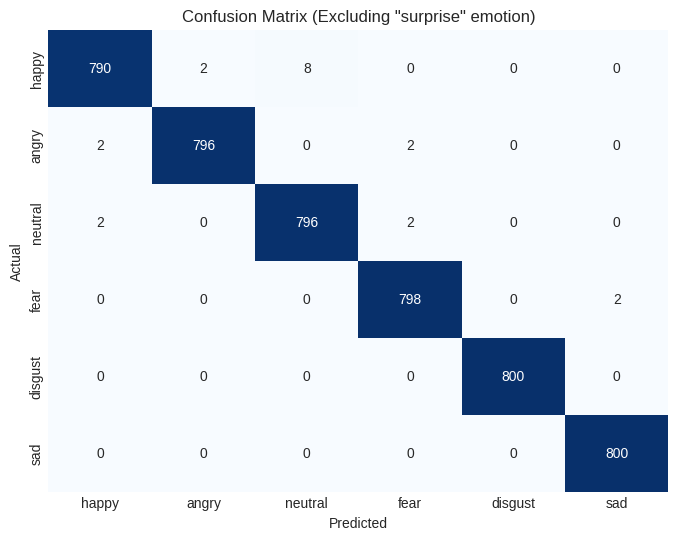

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Filter out rows with 'surprise' emotion from comparison_df
filtered_comparison_df = comparison_df[comparison_df['Actual'] != 'surprise']

# Calculate the confusion matrix
conf_matrix = confusion_matrix(filtered_comparison_df['Actual'], filtered_comparison_df['Predicted'])

# Get the emotion labels for the confusion matrix
emotions = filtered_comparison_df['Actual'].unique()

# Create a DataFrame from the confusion matrix and emotion labels
conf_matrix_df = pd.DataFrame(conf_matrix, index=emotions, columns=emotions)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Excluding "surprise" emotion)')
plt.show()


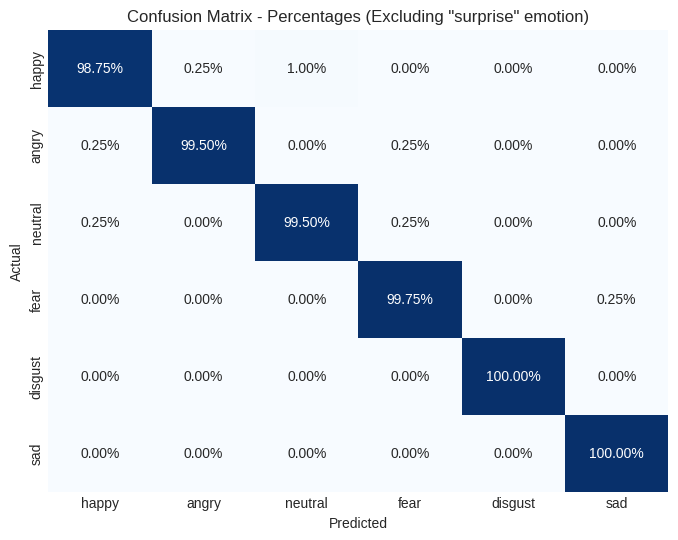

In [ ]:
 #Filter out rows with 'surprise' emotion from comparison_df
filtered_comparison_df = comparison_df[comparison_df['Actual'] != 'surprise']

# Calculate the confusion matrix
conf_matrix = confusion_matrix(filtered_comparison_df['Actual'], filtered_comparison_df['Predicted'])

# Get the emotion labels for the confusion matrix
emotions = filtered_comparison_df['Actual'].unique()

# Calculate percentages
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percentage = conf_matrix / row_sums[:, np.newaxis]

# Create a DataFrame from the percentage confusion matrix and emotion labels
conf_matrix_df_percentage = pd.DataFrame(conf_matrix_percentage, index=emotions, columns=emotions)

# Plot the percentage confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df_percentage, annot=True, fmt=".2%", cmap="Blues", cbar=False)  # Updated fmt to ".2%"
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Percentages (Excluding "surprise" emotion)')
plt.show()

In [ ]:
# Check how many predictions were correct
correct_predictions = comparison_df[comparison_df['Actual'] == comparison_df['Predicted']]
correct_count = len(correct_predictions)

# Check overall accuracy
accuracy = correct_count / len(comparison_df) * 100
print(f"Number of correct predictions: {correct_count}")
print(f"Overall accuracy: {accuracy:.2f}%")

Number of correct predictions: 4780
Overall accuracy: 99.58%


In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(comparison_df['Actual'], comparison_df['Predicted'])

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[790   2   8   0   0   0]
 [  2 796   0   2   0   0]
 [  2   0 796   2   0   0]
 [  0   0   0 798   0   2]
 [  0   0   0   0 800   0]
 [  0   0   0   0   0 800]]


# Tess  Data - SURPRISE

Surpise was not used int eh trianing of the model, important check

In [ ]:
# Load TESS dataset
file_emotion = []
file_path = []

# Path to TESS dataset
tess_path = '/content/drive/My Drive/tess/TESS Toronto emotional speech set data'

# Subfolders to include
included_subfolders = ['OAF_Pleasant_surprise']

def get_emotion_tess(filename):
    # Extract emotion from the filename based on the provided logic
    if 'angry' in filename:
        return 'angry'
    elif 'happy' in filename:
        return 'happy'
    elif 'neutral' in filename:
        return 'neutral'
    elif 'sad' in filename:
        return 'sad'
    elif 'ps' in filename:
        return 'surprise'
    elif 'fear' in filename:
        return 'fear'
    elif 'disgust' in filename:
        return 'disgust'
    else:
        return 'Unknown'

# Loop over the files in TESS dataset
for root, dirs, files in os.walk(tess_path):
    # Check if the current subfolder is included
    subfolder_name = os.path.basename(root)
    if subfolder_name in included_subfolders:
        # Sort files based on their names to maintain order
        for file_name in sorted(files):
            file_emotion.append(get_emotion_tess(file_name))
            file_path.append(os.path.join(root, file_name))

# Create DataFrame for emotions and file paths
tess_df = pd.DataFrame({'Emotions': file_emotion, 'Path': file_path})

# Filter out rows with labels equal to 'Unknown'
tess_df = tess_df[tess_df['Emotions'] != 'Unknown']

# Lists to store actual and predicted emotions
actual_emotions = []
predicted_emotions = []

# Iterate through the TESS dataset and make predictions
for index, row in tess_df.iterrows():
    file_path = row['Path']

    # Preprocess the audio file
    preprocessed_data, target_sr = preprocess_audio_file(file_path, target_sr=16000, target_duration=3.0)

    # Extract features from the preprocessed audio using the updated function
    features = extract_features(preprocessed_data, target_sr)

    # Standardize the features using the loaded scaler
    features_standardized = scaler.transform(features.reshape(1, -1))

    # Reshape the features for the model
    features_reshaped = features_standardized.reshape(1, features_standardized.shape[1], 1)

    # Make predictions
    prediction = model.predict(features_reshaped)

    ## Decode the prediction back to an emotion label
    predicted_emotion_label = label_encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

    # Append actual and predicted emotions
    actual_emotions.append(row['Emotions'])
    predicted_emotions.append(predicted_emotion_label)

    # Display the result
    print(f"File: {file_path}, Actual Emotion: {row['Emotions']}, Predicted Emotion: {predicted_emotion_label}")

# Compare actual and predicted emotions
comparison_df = pd.DataFrame({'Actual': actual_emotions, 'Predicted': predicted_emotions})
print(comparison_df)

Trimmed Duration: 2.03 seconds
Original Max: 0.13985615968704224
Normalized Max: 1.0
Processed Duration: 3.00 seconds
1/1 [==============================] - 0s 21ms/step
File: /content/drive/My Drive/tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_back_ps.wav, Actual Emotion: surprise, Predicted Emotion: angry
Trimmed Duration: 1.92 seconds
Original Max: 0.194838285446167
Normalized Max: 1.0
Processed Duration: 3.00 seconds
1/1 [==============================] - 0s 21ms/step
File: /content/drive/My Drive/tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_bar_ps.wav, Actual Emotion: surprise, Predicted Emotion: disgust
Trimmed Duration: 2.11 seconds
Original Max: 0.2657886743545532
Normalized Max: 1.0
Processed Duration: 3.00 seconds
1/1 [==============================] - 0s 22ms/step
File: /content/drive/My Drive/tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_base_ps.wav, Actual Emotion: surprise, Predicted Emotion: disgus

<ipython-input-74-199f04a093ae>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


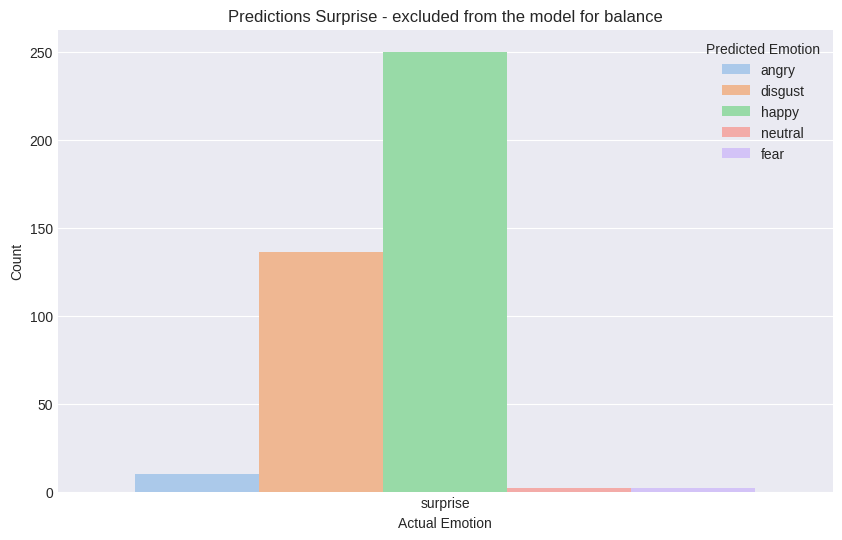

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use('seaborn-darkgrid')

# Filter out 'surprise' and 'calm' from the predictions
filtered_predictions = comparison_df[comparison_df['Actual'].isin(['surprise'])]

# Set Seaborn color palette
sns.set_palette('pastel')

# Create a bar chart for filtered predictions
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_predictions, x='Actual', hue='Predicted', order=['surprise'])
plt.xlabel('Actual Emotion')
plt.ylabel('Count')
plt.title('Predictions Surprise - excluded from the model for balance')
plt.legend(title='Predicted Emotion')
plt.show()

# Scale up to long Form audio

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Function to generate sliding windows
def generate_windows(data, window_size, hop_size):
    num_samples = len(data)
    window_samples = int(window_size * sr)  # Convert window size to samples
    hop_samples = int(hop_size * sr)  # Convert hop size to samples

    # Generate sliding windows
    windows = []
    for i in range(0, num_samples - window_samples + 1, hop_samples):
        window = data[i:i + window_samples]
        windows.append(window)

    return windows


In [ ]:
# Function for consistent audio preprocessing
def preprocess_long_audio(audio_file_path, target_sr=16000, window_size=None, hop_size=None):
    if window_size is None or hop_size is None:
        raise ValueError("Both window_size and hop_size must be provided.")
    data, sr = librosa.load(audio_file_path, sr=target_sr, duration=None)

    # Trim silences
    trimmed_data = trim_silences(data, sr)

    # Normalize the audio
    normalized_data = normalize_audio(trimmed_data)

    # Calculate parameters for sliding windows
    window_samples = int(window_size * target_sr)
    hop_samples = int(hop_size * target_sr)

    # Extract sliding windows
    windows = [normalized_data[i:i + window_samples] for i in range(0, len(normalized_data) - window_samples + 1, hop_samples)]

    # Print processed information
    print(f"Original Duration: {len(trimmed_data) / sr:.2f} seconds")
    print(f"Number of Windows: {len(windows)}")

    return windows, sr

## Test on German Language snippets with high granularity

Testing Window Function

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display
from collections import Counter

# Function to perform predictions on an audio file
def predict_emotions(audio_file_path, window_size, hop_size):
    # Load and preprocess the audio file using your function
    preprocessed_data, sr = preprocess_long_audio(audio_file_path, target_sr=16000, window_size=window_size, hop_size=hop_size)

    # Lists to store predicted emotions, corresponding timestamps, and confidence levels
    all_predicted_emotions = []
    timestamps = []
    confidences = []

    # Iterate through the sliding windows and make predictions
    for i, window_features in enumerate(preprocessed_data):
        # Extract features using your 'extract_features' function
        features = extract_features(window_features, sr)

        # Standardize the features using the loaded scaler
        features_standardized = scaler.transform(features.reshape(1, -1))

        # Reshape the features for the model
        features_reshaped = features_standardized.reshape(1, features_standardized.shape[1], 1)

        # Make predictions with the model
        window_prediction = model.predict(features_reshaped)

        # Get the predicted emotion and corresponding confidence
        predicted_emotion_index = np.argmax(window_prediction)
        predicted_emotion_label = label_encoder.inverse_transform([predicted_emotion_index])[0]
        confidence = window_prediction[0, predicted_emotion_index]

        # Append predicted emotion, timestamp, and confidence
        all_predicted_emotions.append(predicted_emotion_label)
        timestamps.append(i * hop_size)  # Assuming 'hop_size' represents the time between windows
        confidences.append(confidence)

        # Print the prediction details for each window
        print(f"{i + 1}/{len(preprocessed_data)} [{confidence:.2f}] - Time: {i * hop_size:.2f} seconds, Predicted Emotion: {predicted_emotion_label}")



    # Print the predicted emotions and confidence levels for the current audio file
    print(f"\nPredicted Emotions for {audio_file_path}:")
    for time, emotion, confidence in zip(timestamps, all_predicted_emotions, confidences):
        if confidence >= confidence_threshold:
            print(f"Time: {time:.2f} seconds, Predicted Emotion: {emotion}, Confidence: {confidence:.2f}")
        else:
            print(f"Time: {time:.2f} seconds, Predicted Emotion: Unknown (Confidence below threshold)")


    # Count the occurrences of each emotion
    emotion_counts = Counter(all_predicted_emotions)
    plt.figure(figsize=(12, 8))
    bars = plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue', edgecolor='black')

    # Adding labels and title
    plt.xlabel('Emotion', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Predicted Emotion Counts', fontsize=16)

    # Adding value annotations on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

    # Adding grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Removing x-axis ticks and adjusting y-axis limits for better readability
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', which='both', bottom=False)
    plt.ylim(0, max(emotion_counts.values()) + 1)

    # Show the plot
    plt.show()

    # Embed an audio player for the current audio file
    display(Audio(audio_file_path))
    plt.show()


In [ ]:
window_size = 0.5
hop_size = 0.2
confidence_threshold = 0.70

Trimmed Duration: 1.44 seconds
Original Max: 0.999969482421875
Normalized Max: 1.0
Original Duration: 1.44 seconds
Number of Windows: 5
1/1 [==============================] - 0s 44ms/step
1/5 [1.00] - Time: 0.00 seconds, Predicted Emotion: angry
1/1 [==============================] - 0s 39ms/step
2/5 [0.97] - Time: 0.20 seconds, Predicted Emotion: angry
1/1 [==============================] - 0s 56ms/step
3/5 [0.64] - Time: 0.40 seconds, Predicted Emotion: angry
1/1 [==============================] - 0s 53ms/step
4/5 [1.00] - Time: 0.60 seconds, Predicted Emotion: angry
1/1 [==============================] - 0s 41ms/step
5/5 [1.00] - Time: 0.80 seconds, Predicted Emotion: angry

Predicted Emotions for /content/drive/My Drive/German_Berlin/wav/08a01Wa.wav:
Time: 0.00 seconds, Predicted Emotion: angry, Confidence: 1.00
Time: 0.20 seconds, Predicted Emotion: angry, Confidence: 0.97
Time: 0.40 seconds, Predicted Emotion: Unknown (Confidence below threshold)
Time: 0.60 seconds, Predicted Emo

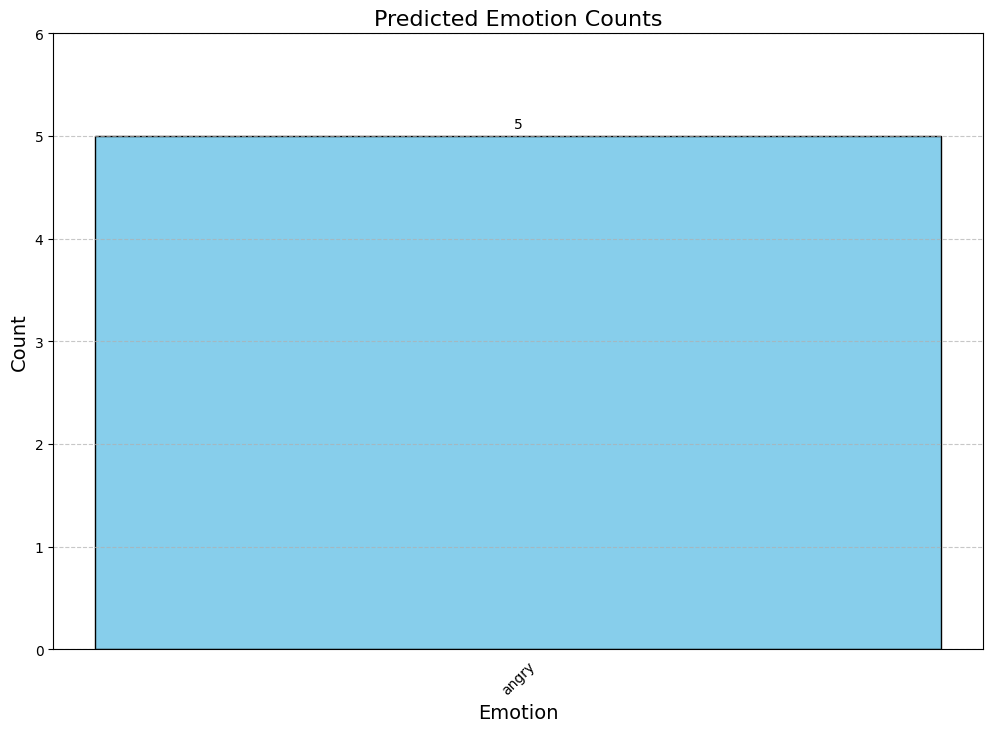

Trimmed Duration: 3.89 seconds
Original Max: 0.999969482421875
Normalized Max: 1.0
Original Duration: 3.89 seconds
Number of Windows: 17
1/1 [==============================] - 0s 56ms/step
1/17 [1.00] - Time: 0.00 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 37ms/step
2/17 [0.89] - Time: 0.20 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 40ms/step
3/17 [1.00] - Time: 0.40 seconds, Predicted Emotion: sad
1/1 [==============================] - 0s 41ms/step
4/17 [1.00] - Time: 0.60 seconds, Predicted Emotion: disgust
1/1 [==============================] - 0s 39ms/step
5/17 [1.00] - Time: 0.80 seconds, Predicted Emotion: sad
1/1 [==============================] - 0s 43ms/step
6/17 [1.00] - Time: 1.00 seconds, Predicted Emotion: sad
1/1 [==============================] - 0s 38ms/step
7/17 [1.00] - Time: 1.20 seconds, Predicted Emotion: sad
1/1 [==============================] - 0s 37ms/step
8/17 [1.00] - Time: 1.40 seconds, Predicte

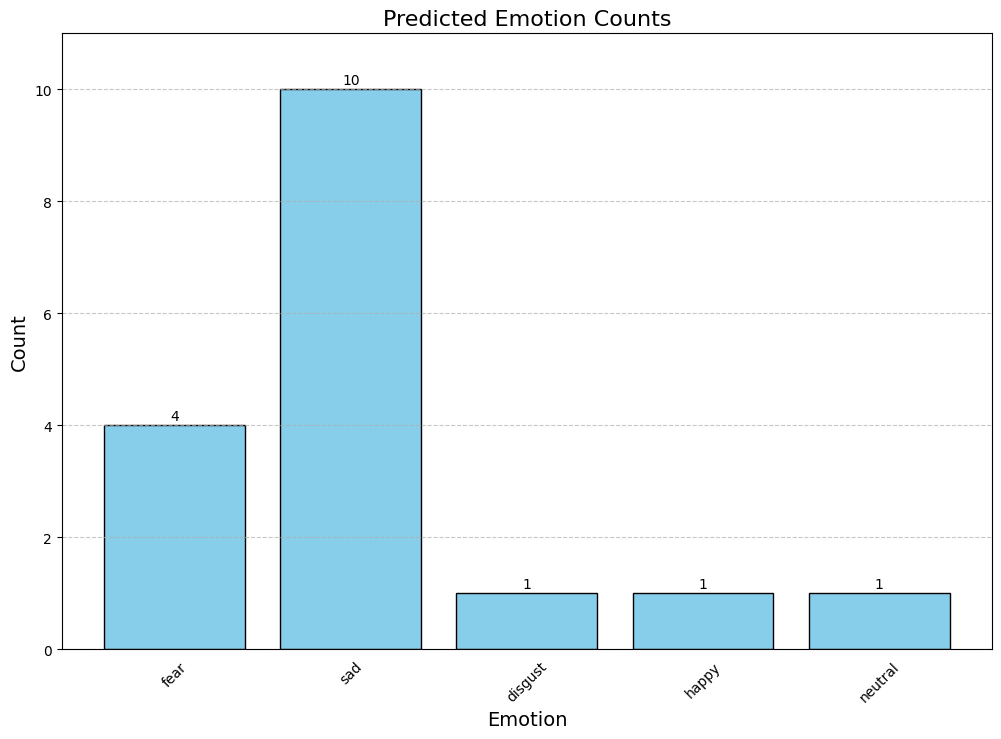

Trimmed Duration: 4.06 seconds
Original Max: 0.999969482421875
Normalized Max: 1.0
Original Duration: 4.06 seconds
Number of Windows: 18
1/1 [==============================] - 0s 46ms/step
1/18 [1.00] - Time: 0.00 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 47ms/step
2/18 [1.00] - Time: 0.20 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 40ms/step
3/18 [1.00] - Time: 0.40 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 40ms/step
4/18 [1.00] - Time: 0.60 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 54ms/step
5/18 [0.98] - Time: 0.80 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 42ms/step
6/18 [0.93] - Time: 1.00 seconds, Predicted Emotion: disgust
1/1 [==============================] - 0s 42ms/step
7/18 [1.00] - Time: 1.20 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 56ms/step
8/18 [0.58] - Time: 1.40 seconds, Pred

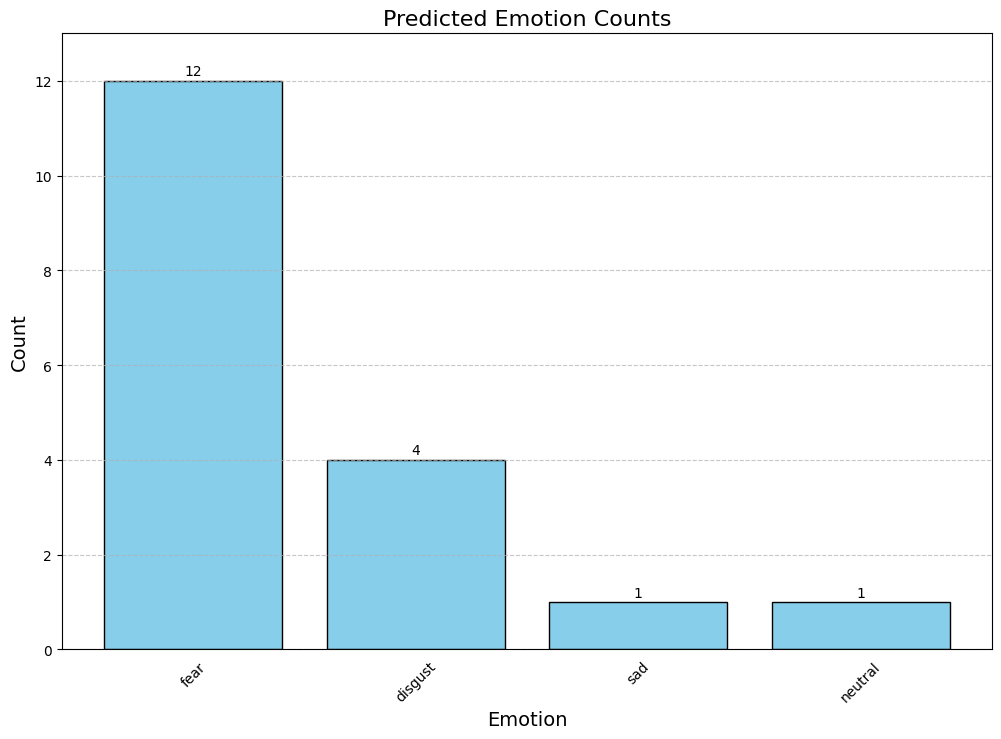

Trimmed Duration: 2.46 seconds
Original Max: 0.99981689453125
Normalized Max: 1.0
Original Duration: 2.46 seconds
Number of Windows: 10
1/1 [==============================] - 0s 65ms/step
1/10 [0.48] - Time: 0.00 seconds, Predicted Emotion: happy
1/1 [==============================] - 0s 51ms/step
2/10 [1.00] - Time: 0.20 seconds, Predicted Emotion: angry
1/1 [==============================] - 0s 29ms/step
3/10 [1.00] - Time: 0.40 seconds, Predicted Emotion: angry
1/1 [==============================] - 0s 60ms/step
4/10 [0.95] - Time: 0.60 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 60ms/step
5/10 [1.00] - Time: 0.80 seconds, Predicted Emotion: angry
1/1 [==============================] - 0s 44ms/step
6/10 [0.99] - Time: 1.00 seconds, Predicted Emotion: happy
1/1 [==============================] - 0s 50ms/step
7/10 [0.98] - Time: 1.20 seconds, Predicted Emotion: happy
1/1 [==============================] - 0s 50ms/step
8/10 [0.93] - Time: 1.40 seconds, Pr

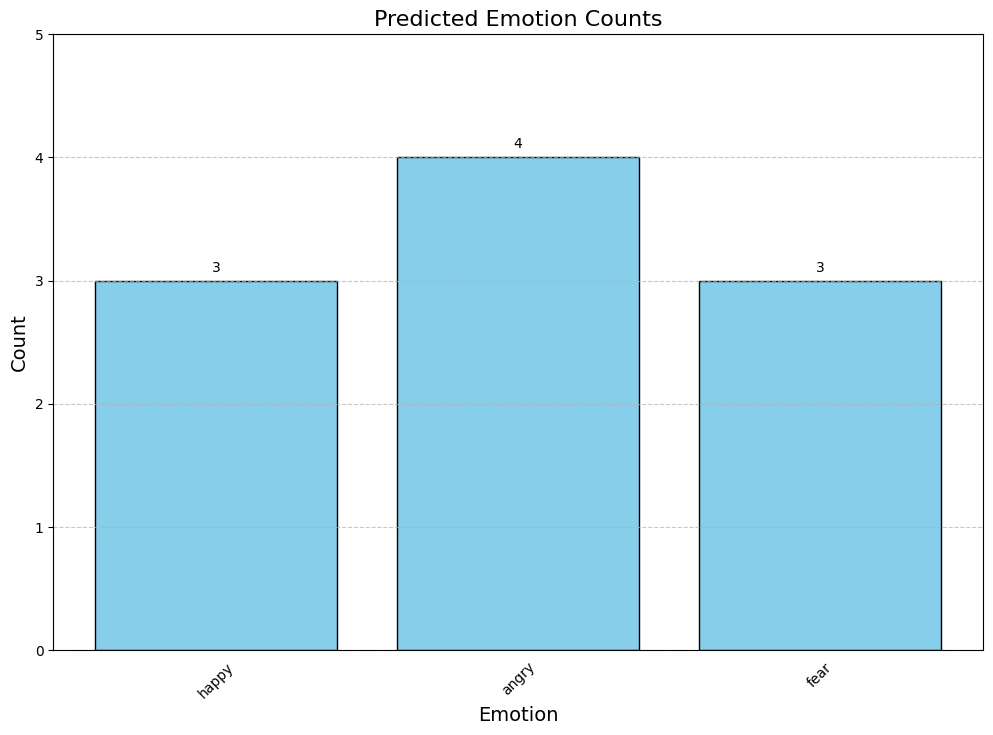

In [ ]:
# List of example audio file paths
audio_file_paths = [
    "/content/drive/My Drive/German_Berlin/wav/08a01Wa.wav",  # Angry
    "/content/drive/My Drive/German_Berlin/wav/11b10Td.wav",  # Sad
    "/content/drive/My Drive/German_Berlin/wav/08a05Lc.wav",  # Bored
    "/content/drive/My Drive/German_Berlin/wav/09b02Wd.wav"  # Angry
]

# Call the function for each audio file
for audio_file_path in audio_file_paths:
    predict_emotions(audio_file_path,window_size, hop_size)

## Test On a Song - Johnny Cash HURT

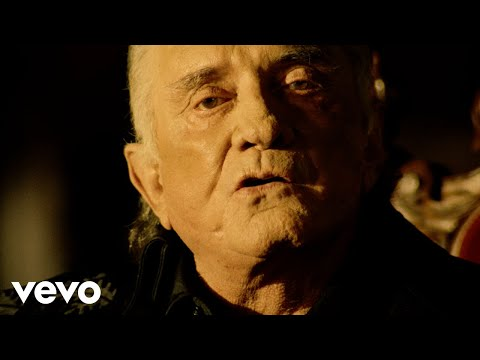

In [ ]:
from IPython.display import YouTubeVideo

# Example usage:
youtube_video_id = "8AHCfZTRGiI"

# Embed the YouTube video
display(YouTubeVideo(youtube_video_id))

In [ ]:
window_size = 1.0
hop_size = 0.2
confidence_threshold =0.8

In [ ]:
# List of example audio file paths
audio_file_path = [
    "/content/drive/My Drive/ensemble_full_v1/Johnny Cash - Hurt.mp3"
]

# Call the function for each audio file
for audio_file_path in audio_file_path:
    predict_emotions(audio_file_path,window_size,hop_size)

Output hidden; open in https://colab.research.google.com to view.

# Trump & Biden Cut

In [ ]:
window_size = 1.0
hop_size = 0.2
confidence_threshold =0.7

In [ ]:
# List of example audio file paths
audio_file_path = [
    "/content/drive/My Drive/ensemble_full_v1/biden_cut.wav"
]

# Call the function for each audio file
for audio_file_path in audio_file_path:
    predict_emotions(audio_file_path,window_size,hop_size)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# List of example audio file paths
audio_file_path = [
    "/content/drive/My Drive/ensemble_full_v1/trump_cut.wav"
]

# Call the function for each audio file
for audio_file_path in audio_file_path:
    predict_emotions(audio_file_path,window_size,hop_size)

Output hidden; open in https://colab.research.google.com to view.

## Tump - Build a Great Wall!

In [ ]:
# Modified predict_emotions function to take time
def predict_emotions_over_timestamps_line_graph(audio_file_path, window_size, hop_size):
    # Load and preprocess the audio file using your function
    preprocessed_data, sr = preprocess_long_audio(audio_file_path, target_sr=16000, window_size=window_size, hop_size=hop_size)

    # Lists to store predicted emotions, corresponding timestamps, and confidence levels
    all_predicted_emotions = []
    timestamps = []
    confidences = []

    # Iterate through the sliding windows and make predictions
    for i, window_features in enumerate(preprocessed_data):
        # Extract features using your 'extract_features' function
        features = extract_features(window_features, sr)

        # Standardize the features using the loaded scaler
        features_standardized = scaler.transform(features.reshape(1, -1))

        # Reshape the features for the model
        features_reshaped = features_standardized.reshape(1, features_standardized.shape[1], 1)

        # Make predictions with the model
        window_prediction = model.predict(features_reshaped)

        # Get the predicted emotion and corresponding confidence
        predicted_emotion_index = np.argmax(window_prediction)
        predicted_emotion_label = label_encoder.inverse_transform([predicted_emotion_index])[0]
        confidence = window_prediction[0, predicted_emotion_index]

        # Append predicted emotion, timestamp, and confidence
        all_predicted_emotions.append(predicted_emotion_label)
        timestamps.append(i * hop_size)  # Assuming 'hop_size' represents the time between windows
        confidences.append(confidence)
         #Print the prediction details for each window
        print(f"{i + 1}/{len(preprocessed_data)} [{confidence:.2f}] - Time: {i * hop_size:.2f} seconds, Predicted Emotion: {predicted_emotion_label}")

    # Print the predicted emotions and confidence levels for the current audio file
    print(f"\nPredicted Emotions for {audio_file_path}:")
    for time, emotion, confidence in zip(timestamps, all_predicted_emotions, confidences):
        if confidence >= confidence_threshold:
            print(f"Time: {time:.2f} seconds, Predicted Emotion: {emotion}, Confidence: {confidence:.2f}")
        else:
            print(f"Time: {time:.2f} seconds, Predicted Emotion: Unknown (Confidence below threshold)")

    # Plot the line graph using the returned variables
    plt.figure(figsize=(12, 5))
    plt.plot(timestamps, all_predicted_emotions, marker='o', linestyle='-', color='b')
    plt.title('Predicted Emotions Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Predicted Emotion')
    plt.show()

    # Embed an audio player for the current audio file
    display(Audio(audio_file_path))
    plt.show()

    # Return predicted emotions, timestamps, and confidences
    return all_predicted_emotions, timestamps, confidences


In [ ]:
# Example usage for a single audio file
single_audio_file_path = "/content/drive/MyDrive/Trump_wall_Mexico_pay.wav"
single_window_size = 2.0
single_hop_size = 0.5

predicted_emotions, timestamps, confidences = predict_emotions_over_timestamps_line_graph(
    single_audio_file_path, window_size=single_window_size, hop_size=single_hop_size
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Example usage for a single audio file
single_audio_file_path = "/content/drive/MyDrive/Trump_wall_Mexico_pay.wav"
single_window_size = 5.0
single_hop_size = 1.5

predicted_emotions, timestamps, confidences = predict_emotions_over_timestamps_line_graph(
    single_audio_file_path, window_size=single_window_size, hop_size=single_hop_size
)

Output hidden; open in https://colab.research.google.com to view.

# Trump Vs The Media

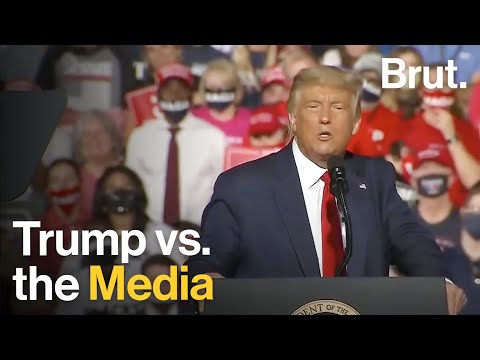

In [ ]:
from IPython.display import YouTubeVideo

# Example usage:
youtube_video_id = "xDdTKBphRMs"

# Embed the YouTube video
display(YouTubeVideo(youtube_video_id))

In [ ]:
def predict_emotions_with_radar(audio_file_path, window_size, hop_size, confidence_threshold):
    # Load and preprocess the audio file using your function
    preprocessed_data, sr = preprocess_long_audio(audio_file_path, target_sr=16000, window_size=window_size, hop_size=hop_size)

    # Lists to store predicted emotions, corresponding timestamps, and confidence levels
    all_predicted_emotions = []
    timestamps = []
    confidences = []

    # Iterate through the sliding windows and make predictions
    for i, window_features in enumerate(preprocessed_data):
        # Extract features using your 'extract_features' function
        features = extract_features(window_features, sr)

        # Standardize the features using the loaded scaler
        features_standardized = scaler.transform(features.reshape(1, -1))

        # Reshape the features for the model
        features_reshaped = features_standardized.reshape(1, features_standardized.shape[1], 1)

        # Make predictions with the model
        window_prediction = model.predict(features_reshaped)

        # Get the predicted emotion and corresponding confidence
        predicted_emotion_index = np.argmax(window_prediction)
        predicted_emotion_label = label_encoder.inverse_transform([predicted_emotion_index])[0]
        confidence = window_prediction[0, predicted_emotion_index]

        # Append predicted emotion, timestamp, and confidence
        all_predicted_emotions.append(predicted_emotion_label)
        timestamps.append(i * hop_size)  # Assuming 'hop_size' represents the time between windows
        confidences.append(confidence)

        # Print the prediction details for each window
        print(f"{i + 1}/{len(preprocessed_data)} [{confidence:.2f}] - Time: {i * hop_size:.2f} seconds, Predicted Emotion: {predicted_emotion_label}")

    # Print the predicted emotions and confidence levels
    print(f"\nPredicted Emotions for {audio_file_path}:")
    for time, emotion, confidence in zip(timestamps, all_predicted_emotions, confidences):
        if confidence >= confidence_threshold:
            print(f"Time: {time:.2f} seconds, Predicted Emotion: {emotion}, Confidence: {confidence:.2f}")
        else:
            print(f"Time: {time:.2f} seconds, Predicted Emotion: Unknown (Confidence below threshold)")

    # Create a set of all possible emotions
    all_emotions = set(label_encoder.classes_)

    # Set the number of emotions and create evenly spaced angles for the radar chart
    num_emotions = len(all_emotions)
    angles = np.linspace(0, 2 * np.pi, num_emotions, endpoint=False).tolist()

    # Create a list of percentages for each emotion, including zeros for those not predicted
    percentages = [all_predicted_emotions.count(emotion) / len(all_predicted_emotions) * 100 if emotion in all_predicted_emotions else 0 for emotion in all_emotions]

    # If the lengths of angles and values do not match, repeat the first value of percentages
    if len(angles) != len(percentages):
        percentages.append(percentages[0])

    # Plot the radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, percentages, color='blue', alpha=0.25)
    ax.set_yticklabels([])
    #ax.set_thetagrids(angles * 180 / np.pi, all_emotions)  # Use all possible emotions for the chart
    ax.set_thetagrids(np.array(angles) * 180 / np.pi, all_emotions)

    ax.set_title('Distribution of Predicted Emotions')
    plt.show()

    # Embed an audio player for the current audio file
    display(Audio(audio_file_path))
    plt.show()

    # Return predicted emotions, timestamps, and confidences
    return all_predicted_emotions, timestamps, confidences

Trimmed Duration: 209.73 seconds
Original Max: 0.5577160120010376
Normalized Max: 1.0
Original Duration: 209.73 seconds
Number of Windows: 1044
1/1 [==============================] - 0s 42ms/step
1/1044 [0.87] - Time: 0.00 seconds, Predicted Emotion: disgust
1/1 [==============================] - 0s 51ms/step
2/1044 [0.78] - Time: 0.20 seconds, Predicted Emotion: sad
1/1 [==============================] - 0s 43ms/step
3/1044 [1.00] - Time: 0.40 seconds, Predicted Emotion: disgust
1/1 [==============================] - 0s 34ms/step
4/1044 [0.98] - Time: 0.60 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 28ms/step
5/1044 [0.50] - Time: 0.80 seconds, Predicted Emotion: fear
1/1 [==============================] - 0s 31ms/step
6/1044 [0.77] - Time: 1.00 seconds, Predicted Emotion: happy
1/1 [==============================] - 0s 36ms/step
7/1044 [1.00] - Time: 1.20 seconds, Predicted Emotion: sad
1/1 [==============================] - 0s 36ms/step
8/1044 [1.00] -

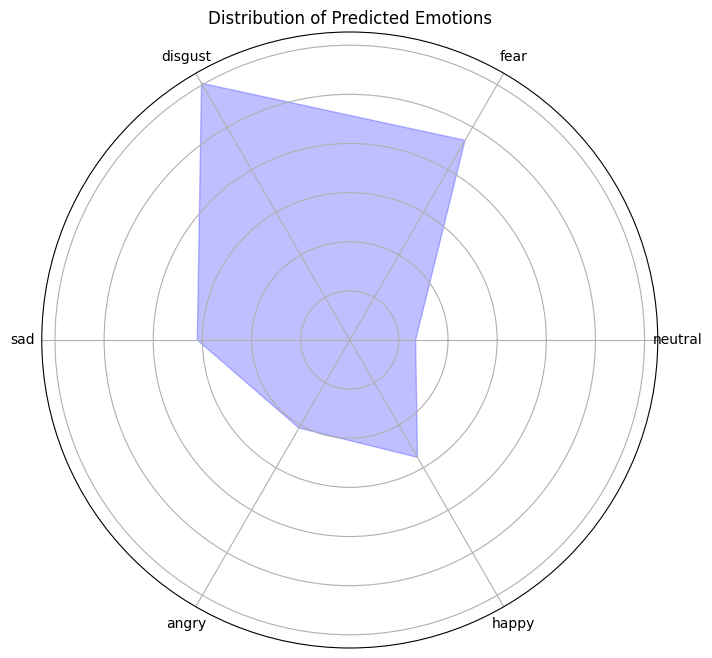

In [ ]:
# Set parameters
window_size = 1.0
hop_size = 0.2
confidence_threshold = 0.7

# Specify the audio file path
audio_file_path = "/content/drive/My Drive/Trump vs. the Media.wav"

# Call the function for the specified audio file
predict_emotions_with_radar(audio_file_path, window_size, hop_size, confidence_threshold)

In [ ]:
window_size = 1.0
hop_size = 0.2
confidence_threshold =0.7

Radar for Trump & Biden Cut

In [ ]:
# Set parameters
window_size = 1.0
hop_size = 0.2
confidence_threshold = 0.7

# Specify the audio file path
audio_file_path = "/content/drive/My Drive/ensemble_full_v1/biden_cut.wav"

# Call the function for the specified audio file
predict_emotions_with_radar(audio_file_path, window_size, hop_size, confidence_threshold)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Set parameters
window_size = 1.0
hop_size = 0.2
confidence_threshold = 0.7

# Specify the audio file path
audio_file_path = "/content/drive/My Drive/ensemble_full_v1/trump_cut.wav"

# Call the function for the specified audio file
predict_emotions_with_radar(audio_file_path, window_size, hop_size, confidence_threshold)

Output hidden; open in https://colab.research.google.com to view.